# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('previsao_de_renda.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   index                  15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12466 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  mau                    15000 non-null  bool   
 15  re

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [4]:


X = df.drop(['Unnamed: 0' , 'data_ref' , 'index', 'mau'], axis = 1)

X.dropna(inplace = True)

X.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 12466 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   12466 non-null  object 
 1   posse_de_veiculo       12466 non-null  bool   
 2   posse_de_imovel        12466 non-null  bool   
 3   qtd_filhos             12466 non-null  int64  
 4   tipo_renda             12466 non-null  object 
 5   educacao               12466 non-null  object 
 6   estado_civil           12466 non-null  object 
 7   tipo_residencia        12466 non-null  object 
 8   idade                  12466 non-null  int64  
 9   tempo_emprego          12466 non-null  float64
 10  qt_pessoas_residencia  12466 non-null  float64
 11  renda                  12466 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 1.1+ MB


In [7]:
# 1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).

X_train, X_test = train_test_split(X, train_size=0.75, random_state=100)


X_train.head()



,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
7879,F,True,True,0,Assalariado,Secundário,Casado,Casa,50,6.715068,2.0,3984.86
2632,F,False,True,0,Empresário,Secundário,Casado,Casa,51,6.630137,2.0,4196.93
3971,F,False,True,0,Assalariado,Superior completo,Casado,Casa,40,8.123288,2.0,2584.87
7140,M,True,True,0,Empresário,Secundário,Casado,Casa,42,3.257534,2.0,3294.94
2972,F,False,True,0,Empresário,Secundário,Viúvo,Casa,54,4.008219,1.0,1969.89


In [16]:
# 2. Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o 𝑅2 na base de testes. 
#Qual o melhor modelo?

modelo = patsy.dmatrices('''renda ~ sexo
                                  + posse_de_veiculo
                                  + C(posse_de_imovel, Treatment(1))
                                  + qtd_filhos
                                  + C(tipo_renda, Treatment(0))
                                  + C(educacao, Treatment(2))
                                  + estado_civil
                                  + C(tipo_residencia, Treatment(1))
                                  + idade
                                  + tempo_emprego
                                  + qt_pessoas_residencia
                                  ''', X_train)
md = smf.ols(modelo, data = df)
reg = md.fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.01)

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     111.6
Date:                Mon, 13 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:54:10   Log-Likelihood:                -91475.
No. Observations:                9349   AIC:                         1.830e+05
Df Residuals:                    9324   BIC:                         1.832e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          -280.2696   2167.813     -0.129      0.897   -4529.657    3969.118
sexo[T.M]                                          2349.9054    101.370     23.182      0.000    2151.199    2548.612
posse_de_veiculo[T.True]                            -49.0602     97.644     -0.502      0.615    -240.463     142.343
C(posse_de_imovel, Treatment(1))[T.False]          -365.7728     96.703     -3.782      0.000    -555.332    -176.213
C(tipo_renda, Treatment(0))[T.Bolsista]           -1704.0002   2486.773     -0.685      0.493   -6578.619    3170.619
C(tipo_renda, Treatment(0))[T.Empresário]          1050.3412    104.138     10.086      0.000     846.207    1254.475
C(tipo_renda, Treatment(0))[T.Pensionista]         1743.7147   1436.856      1.214      0.225   -1072.836    4560.265
C(tipo_renda, Treatment(0))[T.Servidor público]     377.7280    150.227      2.514      0.012      83.250     672.206
C(educacao, Treatment(2))[T.Primário]               200.8314    487.582      0.412      0.680    -754.936    1156.599
C(educacao, Treatment(2))[T.Pós graduação]         2676.7032   1153.122      2.321      0.020     416.332    4937.074
C(educacao, Treatment(2))[T.Superior completo]      621.4883     95.712      6.493      0.000     433.871     809.105
C(educacao, Treatment(2))[T.Superior incompleto]    -57.6126    220.411     -0.261      0.794    -489.666     374.441
estado_civil[T.Separado]                            152.1843   1094.291      0.139      0.889   -1992.866    2297.234
estado_civil[T.Solteiro]                            155.1396   1081.249      0.143      0.886   -1964.344    2274.623
estado_civil[T.União]                               -54.7173    165.480     -0.331      0.741    -379.094     269.659
estado_civil[T.Viúvo]                              -187.3098   1113.577     -0.168      0.866   -2370.164    1995.545
C(tipo_residencia, Treatment(1))[T.Aluguel]         424.1785    380.177      1.116      0.265    -321.051    1169.408
C(tipo_residencia, Treatment(1))[T.Com os pais]    -297.0706    209.045     -1.421      0.155    -706.844     112.703
C(tipo_residencia, Treatment(1))[T.Comunitário]    -155.8199    579.507     -0.269      0.788   -1291.780     980.140
C(tipo_residencia, Treatment(1))[T.Estúdio]        -235.0610    516.188     -0.455      0.649   -1246.901     776.779
C(tipo_residencia, Treatment(1))[T.Governamental]  -330.2434    263.332     -1.254      0.210    -846.432     185.945
qtd_filhos                                         -136.6795   1077.896     -0.127      0.899   -2249.591    1976.232
idade                                                28.1490      5.543      5.079      0.000      17.284      39.014
tempo_emprego  

In [10]:


alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

for i in alpha:
    md = smf.ols(modelo, data = X_train).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 0.00001
                         , alpha = i)
    print(f'R² = {md.rsquared} Adj. R² = {md.rsquared_adj} Alpha = {i} ')



R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0 
R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0.001 
R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0.005 
R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0.01 
R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0.05 
R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0.1 


**Os valores de R² se mantiveram iguais em todos Alpha.**

In [11]:
# 3. Faça o mesmo que no passo 2, com uma regressão LASSO. 
# Qual método chega a um melhor resultado?

alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

for i in alpha:
    md = smf.ols(modelo, data = X_train).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = i)
    print(f'R² = {md.rsquared} Adj. R² = {md.rsquared_adj} Alpha = {i} ')

R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0 
R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0.001 
R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0.005 
R² = 0.23034752240050793 Adj. R² = 0.2283664349420793 Alpha = 0.01 
R² = 0.2303335181338696 Adj. R² = 0.22843514504186735 Alpha = 0.05 
R² = 0.2302310335316512 Adj. R² = 0.22841515134611579 Alpha = 0.1 



**Os valores de Aplha [0, 0.001, 0.005, 0.01] mostraram valores mais elevados de R²**

In [18]:
#4 Rode um modelo stepwise. Avalie o 𝑅2 na vase de testes. Qual o melhor resultado?

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("-----------------")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [19]:
X_step = X_train.drop('renda', axis = 1)
X_step = pd.get_dummies(X_step, columns = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], drop_first=True)

y_step = np.array(X_train[['renda']])

In [20]:
result = stepwise_selection(X_step, y_step)

print('resulting features:')
print(result)

Add  tempo_emprego                  with p-value 0.0
-----------------
['tempo_emprego']
Add  sexo_M                         with p-value 1.8412e-121
-----------------
['tempo_emprego', 'sexo_M']
Add  tipo_renda_Empresário          with p-value 2.08796e-24
-----------------
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário']
Add  educacao_Superior completo     with p-value 5.68231e-11
-----------------
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior completo']
Add  idade                          with p-value 1.09787e-08
-----------------
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior completo', 'idade']
Add  posse_de_imovel_True           with p-value 1.39859e-05
-----------------
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior completo', 'idade', 'posse_de_imovel_True']
Add  tipo_renda_Servidor público    with p-value 0.0138807
-----------------
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Supe

In [22]:

# Regressão do stepwise
reg_stepwise = sm.OLS(y_step, sm.add_constant(pd.DataFrame(X_step[result]))).fit()
reg_stepwise.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     347.9
Date:                Mon, 13 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:01:23   Log-Likelihood:                -91480.
No. Observations:                9349   AIC:                         1.830e+05
Df Residuals:                    9340   BIC:                         1.830e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        -337.4576    221.201     -1.526      0.127    -771.060      96.145
tempo_emprego                 310.5677      7.066     43.952      0.000     296.717     324.419
sexo_M                       2355.8406     94.116     25.031      0.000    2171.353    2540.328
tipo_renda_Empresário        1052.2336    103.736     10.143      0.000     848.888    1255.579
educacao_Superior completo    619.1884     93.063      6.653      0.000     436.764     801.613
idade                          27.3622      5.081      5.385      0.000      17.403      37.322
posse_de_imovel_True          407.1649     94.162      4.324      0.000     222.588     591.742
tipo_renda_Servidor público   370.8081    149.587      2.479      0.013      77.585     664.031
educacao_Pós graduação       2694.7181   1151.605      2.340      0.019     437.321    4952.116
==============================================================================
Omnibus:                     7303.880   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           275651.133
Skew:                           3.432   Prob(JB):                         0.00
Kurtosis:                      28.700   Cond. No.                     1.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#Avaliando o  R²  da base:

reg_stepwise.rsquared



0.2295515245411368

**Usando o stepwise, o R² mostrou diferenças quando ajustados, mesmo que muito pequenas. O ponto positivo é reduzir o número de variáveis e dados para analisar, para ter atenção somente naquelas relevantes.**

**#5 Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?**

O stepwise mostrou que é útil para separar as variáveis mais relevantes. 

Apesar dos modelos Rigde e LASSO mostrarem o R² diretamente, o stepwise parece mostrar mais detalhes.

In [25]:
# 6. Partindo dos modelos que você ajustou, tente melhorar o 𝑅2 na base de testes. 
#Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

modelo = patsy.dmatrices('''np.log(renda) ~ sexo
                                  + posse_de_imovel
                                  + tipo_renda
                                  + educacao
                                  + idade
                                  + tempo_emprego
                                  + np.power(tempo_emprego,2)
                                  ''', X_train)


alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

print('ridge')
for i in alpha:
    md = smf.ols(modelo, data = X_train).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 0.00001
                         , alpha = i)
    print(f'R² = {md.rsquared} Adj. R² = {md.rsquared_adj} Alpha = {i} ')
    
print('')


print('LASSO')
for i in alpha:
    md = smf.ols(modelo, data = X_train).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = i)
    print(f'R² = {md.rsquared} Adj. R² = {md.rsquared_adj} Alpha = {i} ')

ridge
R² = 0.24872006799153845 Adj. R² = 0.2476738292003109 Alpha = 0 
R² = 0.24872006799153845 Adj. R² = 0.2476738292003109 Alpha = 0.001 
R² = 0.24872006799153845 Adj. R² = 0.2476738292003109 Alpha = 0.005 
R² = 0.24872006799153845 Adj. R² = 0.2476738292003109 Alpha = 0.01 
R² = 0.24872006799153845 Adj. R² = 0.2476738292003109 Alpha = 0.05 
R² = 0.24872006799153845 Adj. R² = 0.2476738292003109 Alpha = 0.1 

LASSO
R² = 0.24872006799153845 Adj. R² = 0.2476738292003109 Alpha = 0 
R² = 0.24772083148779178 Adj. R² = 0.24699585959394765 Alpha = 0.001 
R² = 0.24579001145034063 Adj. R² = 0.24522481822479214 Alpha = 0.005 
R² = 0.24223177295032516 Adj. R² = 0.2417450881545321 Alpha = 0.01 
R² = 0.22942504880734782 Adj. R² = 0.22909517939330992 Alpha = 0.05 
R² = 0.22942504880734782 Adj. R² = 0.22909517939330992 Alpha = 0.1 


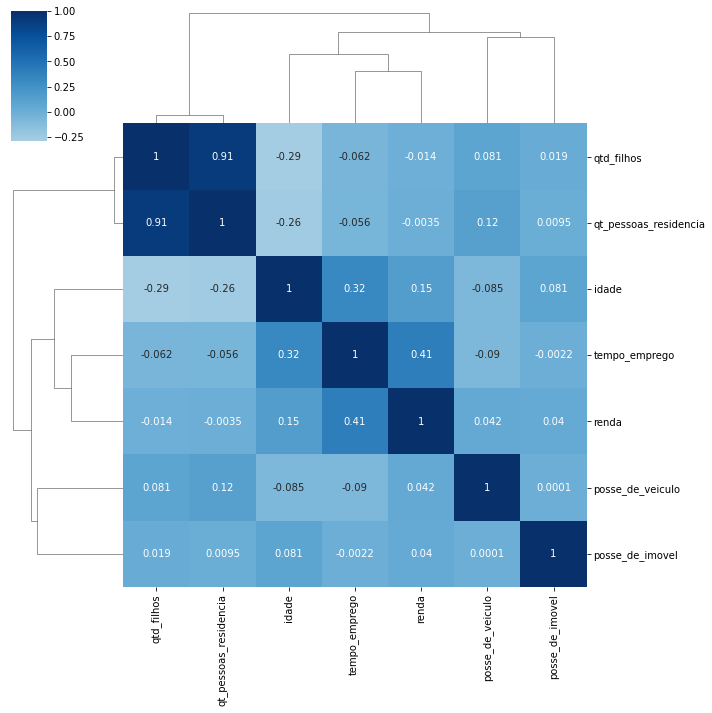

In [30]:


# 7. Ajuste uma árvore de regressão e veja se consegue um 𝑅2 melhor com ela.

sns.clustermap(X_train.corr(), figsize = (10, 10), annot = True, center = 0, cmap = 'Blues')



In [31]:
regtree = DecisionTreeRegressor(max_depth=4)

regtree.fit(X_step, y_step)

DecisionTreeRegressor(max_depth=4)

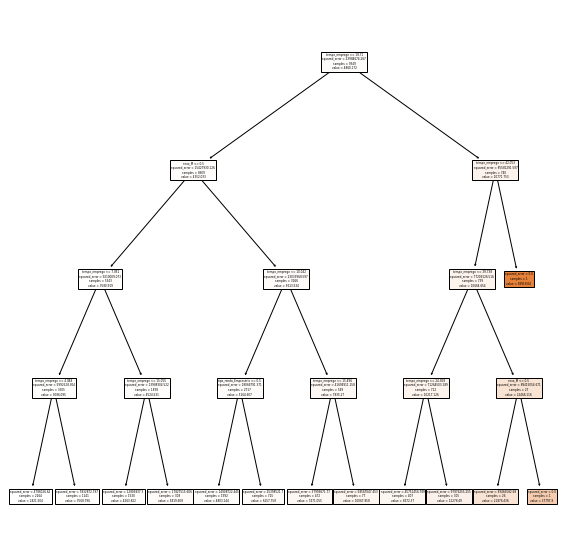

In [32]:


plt.rc('figure', figsize=(10, 10))

tp = tree.plot_tree(regtree, 
                    feature_names=X_step.columns,  
                    filled=True) 



In [36]:
rsquared = regtree.score(X_step, y_step)

template = 'O R² da árvore de treino com profundidade = {0} é: {1:.2f}'
print(template.format(regtree.get_depth(),rsquared).replace(".",","))

O R² da árvore de treino com profundidade = 4 é: 0,26


**O resultado obtido com a arvore de regressão mostrou um resultado maelhor para o R², afinal aumentou de 0.23 para 0.26**